In [1]:
import trackpy as tp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/viva/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
traj_file = '/home/viva/Data/testing_code/filtered_data_tracer+janus_3%_H2O2_13(green)2016-06-14_pickled.pkl'

In [3]:
t1 = pd.read_pickle(traj_file)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd56e4d9fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd530d3ac90>]], dtype=object)

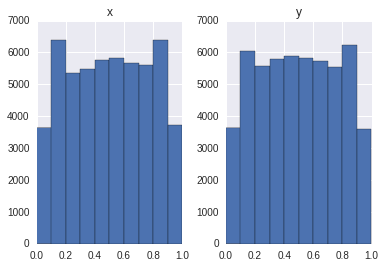

In [4]:
tp.subpx_bias(t1)
## Note that there is subpixel bias so this might not be the best tracking.

In [5]:
## concatenate a new numerical column to a matrix
def put_z_position_in_matrix(mat2D, z=0):
    z_position = np.zeros(len(mat2D)) + z
    z_position = np.matrix(z_position)
    
    mat3D = np.concatenate((mat2D.T, z_position))
    mat3D = mat3D.T
    
    return mat3D

## Check to see if dataframe has z column; otherwise assume z=0.
def get_3D_matrix_from_dataframe(df, xlabel='x',ylabel='y',zlabel='z'):
    try:
        matrix = np.mat(df[[xlabel,ylabel,zlabel]])
    except KeyError:
        matrix = np.mat(df[[xlabel,ylabel]])
        matrix = put_z_position_in_matrix(matrix,0)
        
    return matrix

## The variable A_3D will be a matrix consisting of 
## all coordinates in frame i 
## whose particle is also tracked in frame f.

## The variable B_3D will be a matrix consisting of 
## all coordinates in frame i 
## whose particle is also tracked in frame f.

## This function currently assumes the particles tracked in the image frame 
## are all at the same z.

def matrices_from_dataframe(t1, framei, framef=None, z=0):
    
    # set default for final frame
    if framef == None:
        framef = framei+1
    
    # an inner merge will drop any rows for 
    # particles that are not in both frames 
    AB = pd.merge(t1[t1['frame'] == framei], 
                  t1[t1['frame'] == framef], 
                  how='inner', 
                  on='particle',
                  suffixes=('_i','_f'))

    # Pull out the coordinates and convert to matrices.
    # If z positions are not available, they are set to zero.
    A_3D = get_3D_matrix_from_dataframe(AB, xlabel='x_i',ylabel='y_i',zlabel='z_i')
    B_3D = get_3D_matrix_from_dataframe(AB, xlabel='x_f',ylabel='y_f',zlabel='z_f')
    
    assert len(A_3D) == len(B_3D)
    
    return A_3D, B_3D


## Given a matrix B which 
## has experienced rotation R and translation t, 
## undo that transformation.
def rotational_drift_subtraction(B, R, t):
    n = len(B)
    drift_subtracted = R.T * (B.T - np.tile(t,(1,n)))
    drift_subtracted = drift_subtracted.T
    
    return drift_subtracted

## This function is copied from http://nghiaho.com/uploads/code/rigid_transform_3D.py_
# Input: expects Nx3 matrix of points
# Returns R,t
# R = 3x3 rotation matrix
# t = 3x1 column vector

def rigid_transform_3D(A, B):
    assert len(A) == len(B)

    N = A.shape[0]; # total points

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    
    # centre the points
    AA = A - np.tile(centroid_A, (N, 1))
    BB = B - np.tile(centroid_B, (N, 1))

    # dot is matrix multiplication for array
    H = np.transpose(AA) * BB

    U, S, Vt = np.linalg.svd(H)

    R = Vt.T * U.T

    # special reflection case
    if np.linalg.det(R) < 0:
       print "Reflection detected"
       Vt[2,:] *= -1
       R = Vt.T * U.T

    t = -R*centroid_A.T + centroid_B.T

    #print t

    return R, t

# Calculate the axis and angle of rotation for a given rotation matrix R

def axis_angle(R):
    h = R[2,1]
    f = R[1,2]
    c = R[0,2]
    g = R[2,0]
    d = R[1,0]
    b = R[0,1]
    
    # axis of rotation
    axis = [h-f, c-g, d-b]
    
    # angle of rotation, in radians
    angle = np.arccos((np.trace(R) - 1)/2) 
    
    ## different way to calculate angle
    # axis_length = np.linalg.norm(axis)
    # angle = np.arcsin(axis_length/2) 
    
    return np.mat(axis), angle # in radians

def print_head(matrix, max_printable_length = 10):
    if len(matrix)>max_printable_length:
        print matrix[0:max_printable_length]
        print "..."
    else:
        print matrix



In [6]:
t1.head()

,x,y,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,828.121180,129.191394,2563.183452,4.370820,0.049964,26.254952,11107.0,0.121962,0,1.0
1,830.539380,130.297672,2482.844653,4.240041,0.019197,27.200767,11009.0,0.106690,1,1.0
2,831.040835,131.608294,2024.622337,4.250034,0.028815,22.736953,10555.0,0.134784,2,1.0
3,831.868216,131.174132,2411.716703,4.408588,0.022288,24.990006,11025.0,0.120742,3,1.0
4,830.780880,131.510550,2184.927061,4.321200,0.031905,23.546084,10659.0,0.130048,4,1.0


In [7]:
t1.frame.min()

0

In [8]:
t1.frame.max()

1478

In [9]:
len(t1.frame.unique())

1479

In [10]:
## How many frames to drift-subtract?
max_frame = t1.frame.max()
max_frame = 200 # for debugging

# Set this to false if you don't care about calculating tm
# and just want to plot the drift.
# Drift subtraction is slow; there's a loop inside a loop.
do_drift_subtraction = True; 

## Initialize loop
if do_drift_subtraction:
    tm=0    # overwrite tm
    del tm  # erase tm
prev_frame = None;
R_list = []
t_list = []
x_drifts = []
y_drifts = []
z_drifts = []
axis_list = []
angle_list = []
frame_list = []
verbose = False

labelx = 'x'
labely = 'y'
labelz = 'z'
transformed_str = '_drift_subtracted'
labelx2 = labelx + transformed_str
labely2 = labely + transformed_str
labelz2 = labelz + transformed_str
labelnote = 'relative_to_frame'

for current_frame in sort(t1.frame.unique()):
    
    if current_frame > max_frame:
        break; 
        
    if verbose:
        print "Frame ", current_frame
    
    if prev_frame is None:
        relative_to = current_frame;
        prev_frame = current_frame;
        continue;  # skip first frame
    
    assert prev_frame is not None
    
    # A is a shorthand for the previous frame.
    # B is a shorthand for the current frame.
    
    # Get raw coordinates from current frame and previous frame
    A_3D, B_3D = matrices_from_dataframe(t1, prev_frame, current_frame)

    # Figure out the transformation that occured between frames
    ret_R, ret_t = rigid_transform_3D(A_3D, B_3D);
    
    # Save a copy of the transformation
    R_list.append(ret_R)
    t_list.append(ret_t)
    x_drifts.append(np.array(ret_t)[0][0])
    y_drifts.append(np.array(ret_t)[1][0])
    z_drifts.append(np.array(ret_t)[2][0])
    current_axis,current_angle = axis_angle(ret_R)
    axis_list.append(current_axis)
    angle_list.append(current_angle)
    frame_list.append(current_frame)
    
    if do_drift_subtraction:
        ## Do the rotational drift subtraction.
        ## I need to do this with all particles in current frame, 
        ## not just the ones that also appear in previous frame.
        
        B_dataframe = t1[t1['frame'] == current_frame].copy()
        B = get_3D_matrix_from_dataframe(B_dataframe)
    
        for R,t in zip(reversed(R_list),reversed(t_list)):
            if verbose:
                print "undoing transformation" 
                print R
            B = rotational_drift_subtraction(B, R, t)
            # This is rather brute force, 
            # but I wanted to make sure I'm correct first.
            # The better thing to do is probably to calculate 
            # the total transformation before transforming the coordinates.
    
        ## Record the drift-subtracted coordinates
        # (i.e. Put the transformed data in the dataframe)
    
        x_sub_data = np.array(B[:,0]).T[0]
        y_sub_data = np.array(B[:,1]).T[0]
        z_sub_data = np.array(B[:,2]).T[0]
    
        B_dataframe[labelx2]=x_sub_data
        B_dataframe[labely2]=y_sub_data
    
        if not np.array_equal(z_sub_data, np.zeros_like(z_sub_data)):
            ## Not tested with a z column
            B_dataframe[labelz2]=z_sub_data
            num_new_cols = 4
        else:
            ## no z data
            num_new_cols = 3
        
        B_dataframe[labelnote] = relative_to
            
        try:
            tm = pd.concat([tm, B_dataframe])
        except NameError:
            # Initialize tm
            tm = B_dataframe.copy()
                    
    prev_frame = current_frame;
    
    # end loop
    
## Rename some columns in tm
if do_drift_subtraction:
    # Put the new columns up front
    cols = tm.columns.tolist()
    cols = cols[-num_new_cols:]+cols[:-num_new_cols]
    tm = tm.reindex(columns=cols);
        
    ## Rename raw columns
    tm = tm.rename(index=str,
                   columns={labelx: labelx + "_raw", 
                            labely: labely + "_raw"});
    tm = tm.rename(index=str,
                   columns={labelx2: labelx,
                            labely2: labely});
    
    if num_new_cols == 4:
        ## Not tested with a z column
        tm = tm.rename(index=str, 
                       columns={labelz: labelz + "_raw"});
        tm = tm.rename(index=str,
                       columns={labelz2: labelz});

In [11]:
tm.tail()

,x,y,relative_to_frame,x_raw,y_raw,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,,,,
200,785.922558,238.830858,0,773.934351,203.801444,4647.887432,4.299040,0.008074,52.111742,15959.0,0.043346,200,1259.0
200,1152.277284,742.475319,0,1151.236716,699.297613,965.095753,4.258311,0.091207,11.656574,10158.0,0.154478,200,1287.0
200,355.894229,456.274113,0,348.773769,430.615049,1291.136982,4.196387,0.060226,15.427818,9975.0,0.168071,200,1296.0
200,487.062991,762.233255,0,486.615056,733.626634,1312.393088,4.302772,0.052782,15.770659,9916.0,0.172979,200,1298.0
200,600.052669,198.521229,0,587.225843,167.574176,991.494464,4.410631,0.059407,10.628053,10547.0,0.131815,200,1311.0


In [12]:
len(t1.frame[0:max_frame])

200

In [13]:
len(frame_list)

200

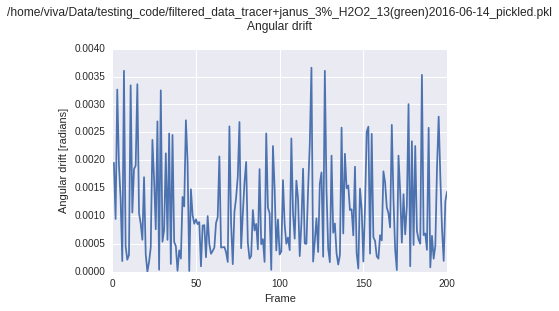

In [14]:
plt.plot(frame_list,angle_list)
plt.title(traj_file + '\nAngular drift\n')
plt.xlabel('Frame')
plt.ylabel('Angular drift [radians]')

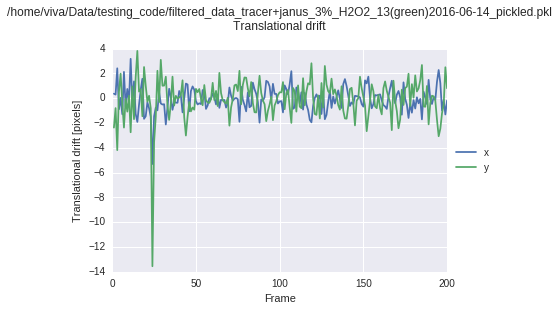

In [15]:
plt.plot(frame_list,x_drifts, label="x")
plt.plot(frame_list,y_drifts, label="y")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(traj_file + '\nTranslational drift\n')
plt.xlabel('Frame')
plt.ylabel('Translational drift [pixels]')

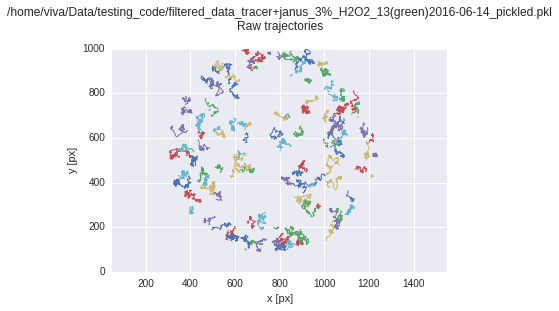

In [16]:
pylab.axis('equal')
plt.title(traj_file + '\nRaw trajectories\n')
ax = tp.plot_traj(t1[t1['frame'] < max_frame], legend=False)

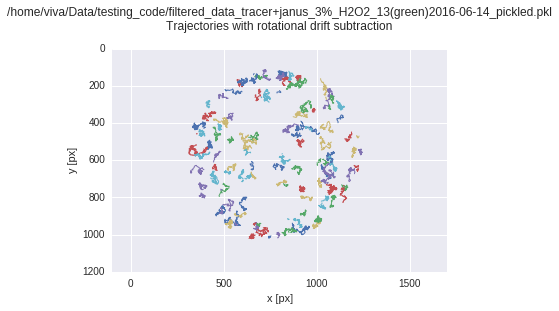

In [17]:
pylab.axis('equal')
plt.title(traj_file + '\nTrajectories with rotational drift subtraction\n')
ax = tp.plot_traj(tm, legend=False)